# 任务4 二维核SVM分类问题


## 4.1 生成数据
1. 在二维平面上以两个x1x2的高斯分布各个随机生成80个样本点
2. 𝑋1样本点作为-1类， 𝑋2 样本点作为+1类，
3. 按照40:20:20划分为“训练集”、“验证集”、“测试集”，并绘制。

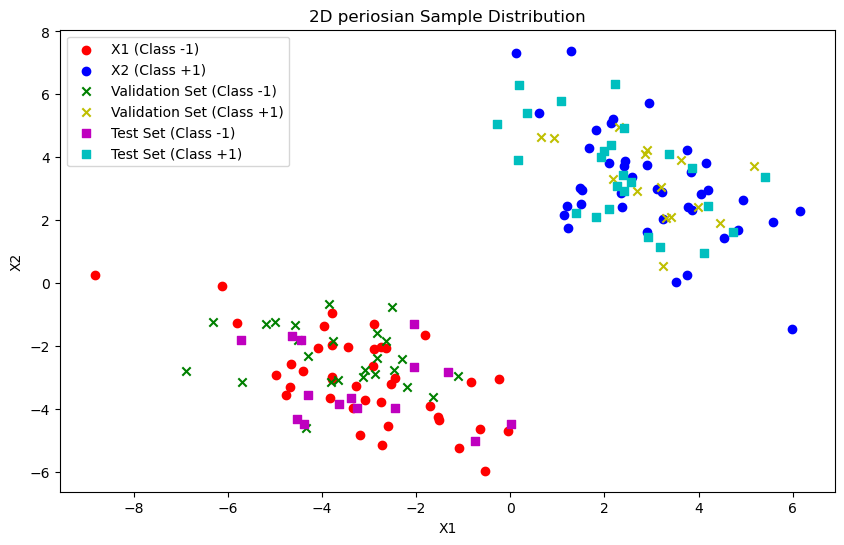

In [289]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt

# 设置随机种子以便重现结果
# np.random.seed(0)

# 生成X1的样本点
mean_x1 = [-3, -3]
cov_x1 = [[2, -1], [-1, 2]]
x1_samples = np.random.multivariate_normal(mean_x1, cov_x1, 80)

# 生成X2的样本点
mean_x2 = [3, 3]
cov_x2 = [[2, -1], [-1, 2]]
x2_samples = np.random.multivariate_normal(mean_x2, cov_x2, 80)

# 合并两个类别的样本点
all_samples = np.vstack((x1_samples, x2_samples))
labels = np.hstack((np.full(80, -1), np.full(80, 1)))

# 为提高泛化能力，随机打乱样本点的顺序
permutation = np.random.permutation(len(all_samples)) # x索引的随机排列
all_samples = all_samples[permutation]
labels = labels[permutation]

# 划分数据集
train_size = 40
validation_size = 20
test_size = 20

X_train = all_samples[:train_size * 2] # 前80
X_val = all_samples[train_size * 2: (train_size + validation_size) * 2] # 中40
X_test = all_samples[(train_size + validation_size) * 2:] # 后40
y_train = labels[:train_size * 2]
y_val = labels[train_size * 2: (train_size + validation_size) * 2]
y_test = labels[(train_size + validation_size) * 2:]


# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(X_train[y_train == -1][:, 0], # 第一维度特征
             X_train[y_train == -1][:, 1], # 第二维度特征
             label='X1 (Class -1)', c='r')
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label='X2 (Class +1)', c='b')

plt.scatter(X_val[y_val == -1][:, 0], X_val[y_val == -1][:, 1], label='Validation Set (Class -1)', c='g', marker='x')
plt.scatter(X_val[y_val == 1][:, 0], X_val[y_val == 1][:, 1], label='Validation Set (Class +1)', c='y', marker='x')

plt.scatter(X_test[y_test == -1][:, 0], X_test[y_test == -1][:, 1], label='Test Set (Class -1)', c='m', marker='s')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], label='Test Set (Class +1)', c='c', marker='s')

plt.legend()
plt.title("2D periosian Sample Distribution")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


## 4.2 核SVM实现
基于python和numpy，以及cvxopt设计并实现核SVM模型。 分别利用linear_kernel 、 ploy_kernel 、 sqexp_kernel 、periodic_kernel实现四个不同的核SVM模型。

In [290]:
current_seed = np.random.get_state()[1][0]
print("当前随机种子:", current_seed)

当前随机种子: 3249685327


In [291]:
# 线性核
def linear_kernel(x, z):
    return np.dot(x.T, z)

# 多项式核
def poly_kernel(x, z, c = 3, p = 1 ):
    return (np.dot(x.T, z) + c) ** p

# 高斯核
def gaussian_kernel(x, z, l=1):
    k = np.exp(-np.dot((x-z).T, (x-z)) / (l ** 2))
    return k

# 周期核
def periodic_kernel(x, z, p=2, l=2):
    return np.exp(-0.5 * (np.sin((np.pi / p) * np.linalg.norm(x - z)) ** 2) / (l ** 2))

### 关于核SVM技巧
svm核技巧要求的模型如下所示  
min：$$ \frac{1}{2} \sum_{i=1}^{n}\sum_{j=1}^{n} \alpha_{i}\alpha_{j}y_{i}y_{j}K(x_{i},x_{j}) - \sum_{i=1}^{n}\alpha_{i} $$ 
约束： $$ \sum_{i=1}^{n} \alpha_{i}y_{i} = 0 $$ 
$$ 0\leq \alpha_{i} \leq C, \text{ for } i = 1,2,...,n $$

查阅到，等式不等式联合约束QP模型如下
 $$ \begin{aligned} min &\; \frac{1}{2}x^TPx + q^Tx\\ s.t. & \;a^T_ix = b_i, i \in E\\  &g^T_jx \leq h_j,j\in I\\  \end{aligned} $$




### 关于[cvxopt.solvers.qp](https://cvxopt.org/userguide/coneprog.html?highlight=qp#cvxopt.solvers.qp)方法

cvxopt.solvers.qp(P, q[, G, h[, A, b[, solver[, initvals]]]])
需要以下参数：
+ P（Problem Matrix）：一个对称矩阵，通常表示为二阶导数矩阵。它对应于优化问题的二次项系数。
+ q（Linear Coefficients Vector）：一个列向量，通常表示为一阶导数向量。它对应于优化问题的一次项系数。
+ G（Inequality Constraints Matrix）：不等式约束的系数矩阵。
+ h（Inequality Constraints Vector）：不等式约束的右侧向量。
+ A（Equality Constraints Matrix）：等式约束的系数矩阵。
+ b（Equality Constraints Vector）：等式约束的右侧向量。

变量设计如下：  
1. **计算核矩阵 $P$**：根据给定的核函数 $ K(x_{i}, x_{j})$ 和训练数据，计算核矩阵P。 $P_{ij} = y_{i}y_{j}K(x_{i}, x_{j})$。这个矩阵是QP问题的目标函数系数矩阵。

2. **目标函数的系数向量 $q$**：目标函数是 $\frac{1}{2} \alpha^T P \alpha - \mathbf{1}^T \alpha$，所以系数向量 $q = [-1, -1, ..., -1]$，包含 n 个元素。

3. **不等式约束的系数矩阵 $G$ 和向量 $h$**：$G$ 是 $ 2n \times n$ 的矩阵，每行对应一个不等式约束，2n行能够响应2个不等式约束，前n为$ E $，后n行为$-E$。 $h$ 是一个长度为 $2n$ 的列向量，为 $[C, C, C, ..., 0, 0]$。

4. **等式约束的系数矩阵 $A$ 和向量 $b$**：$A$是一个 $ 1 \times n$ 的矩阵，每列 $ a_{i}=y_i$ 。 $b$ 是一个长度为 1 的0向量。



### 4.2.1 模型设计部分

In [292]:
def get_P(X, y, kernel_func, kernel_params =[{}]):
    n = X.shape[0]
    P = np.zeros((n,n))

    for i in range(n):
        for j in range(n):
            temp = y[i]* y[j] * kernel_func(X[i], X[j], **kernel_params)
            P[i,j] = temp

    return P
# print(get_P(X_train,y_train,periosian_kernel))

def get_q(X):
    q =  - np.ones((X.shape[0],1))
    
    return q
# print(get_q(X_train))

def get_G(X):
    G = np.vstack((np.eye(X.shape[0]),-np.eye(X.shape[0])))

    return G
# print(get_G(X_train))

def get_h(X, num_c):
    h = np.vstack((num_c*np.ones((X.shape[0],1)),np.zeros((X.shape[0],1))))

    return h
# print(get_h(X_train, 5))

def get_A(y):
    n = y.shape[0]
    A = np.zeros((1,n))

    for i in range(n):
        A[0][i] = y[i]
    
    return A
# print(get_A(y_train))

def get_b():
    b = np.zeros(1)

    return b
# print(get_b())

# 超参数
num_c = 0.1
kernel_func = linear_kernel
kernel_params = {}

P = cvxopt.matrix(get_P(X_train, y_train, kernel_func, kernel_params={}))
q = cvxopt.matrix(get_q(X_train))
G = cvxopt.matrix(get_G(X_train))
h = cvxopt.matrix(get_h(X_train, num_c))
A = cvxopt.matrix(get_A(y_train))
b = cvxopt.matrix(get_b())


solution = cvxopt.solvers.qp(P, q, G, h, A, b)
alpha = np.array(solution['x'])

# 找到支持向量
min_lim = num_c/10
support_vectors_indices = temp_support_vectors_indices = np.where(np.logical_and(num_c  > alpha, alpha > min_lim))[0]

# while True:   # 尽可能减少支持向量的个数
#     if support_vectors_indices.__len__() > 0 and min_lim < num_c/10 : # 防止少到没有
#         min_lim += (num_c - min_lim)/1000 + 1e-10
#         # min_lim *= 1.00001
#         temp_support_vectors_indices = support_vectors_indices
#         support_vectors_indices = np.where(np.logical_and(num_c  > alpha, alpha > min_lim))[0]
#     else:
#        break
# support_vectors_indices = temp_support_vectors_indices


while True:   
    if support_vectors_indices.__len__() < 1 : # 防止少到没有
        min_lim *= 0.99
        # min_lim *= 1.00001
        support_vectors_indices = np.where(np.logical_and(num_c  > alpha, alpha > min_lim))[0]
    else:
        break

# support_vectors_indices = np.where(np.logical_and(num_c > alpha, alpha > 1e-5))[0]

support_vectors_alpha = alpha[support_vectors_indices]
support_vectors_x = X_train[support_vectors_indices]
support_vectors_y = y_train[support_vectors_indices]

print(support_vectors_indices)

b = 0
b_list=np.zeros(support_vectors_x.shape[0])
# 用所有支持向量计算
for j in range(support_vectors_x.shape[0]):
    for i in range(support_vectors_x.shape[0]): 
        b_list[j] += (support_vectors_alpha[i].item() * support_vectors_y[i] * kernel_func(support_vectors_x[i] ,support_vectors_x[j], **kernel_params)).item()
    b_list[j] = (support_vectors_y[j] - b_list[j])
b = np.mean(b_list)
    
# prediction
y_pred = np.zeros(len(X_test))
y = 0
for j in range(X_test.shape[0]):
    y = 0
    for i in range(support_vectors_x.shape[0]):
        y += support_vectors_alpha[i].item() *  support_vectors_y[i] * kernel_func(X_test[j] ,support_vectors_x[i], **kernel_params)

    y_pred[j] = (y + b).item()

y_p = np.sign(y_pred)

# 计算准确率
accuracy = 0
for i in range(X_test.shape[0]):
    if y_p[i] == y_test[i]:
        accuracy += 1
print("Accuracy:", accuracy)

[ 1 27]
Accuracy: 40


In [293]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, make_scorer

# 为了使用GridSearchCV需要自定义一个类
class my_ksvm(BaseEstimator):
    # 初始化类
    def __init__(self, kernel_func, kernel_params= None, num_c = 0.1, flag = 1):
        self.kernel_func = kernel_func
        self.num_c = num_c
        self.kernel_params = kernel_params
        self.flag = flag # 获取支持向量的方法


    def fit(self, x, y):
        self.P = cvxopt.matrix(get_P(x, y, kernel_func=self.kernel_func, kernel_params=self.kernel_params))
        self.q = cvxopt.matrix(get_q(x))
        self.G = cvxopt.matrix(get_G(x))
        self.h = cvxopt.matrix(get_h(x, self.num_c))
        self.A = cvxopt.matrix(get_A(y))
        self.b = cvxopt.matrix(get_b())

        self.x = x
        self.y = y

        # 使用cvxpot库进行问题求解
        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(self.P, self.q, self.G, self.h, self.A, self.b)
        alpha = np.array(solution['x'])

        # 找到支持向量
        min_lim = 1e-10
        support_vectors_indices = temp_support_vectors_indices = np.where(np.logical_and(self.num_c  > alpha, alpha > min_lim))[0]

        # 1
        if self.flag == 1:
            while True:   # 尽可能减少支持向量的个数
                if support_vectors_indices.__len__() > 0 and min_lim < num_c/100 : # 防止少到没有
                    min_lim += (self.num_c - min_lim)/1000 + 1e-10
                    # min_lim *= 1.00001
                    temp_support_vectors_indices = support_vectors_indices
                    support_vectors_indices = np.where(np.logical_and(self.num_c  > alpha, alpha > min_lim))[0]
                else:
                    break
            support_vectors_indices = temp_support_vectors_indices
        
        # 2
        if self.flag == 2 :
            min_lim = 1e-3
            while True:   
                if support_vectors_indices.__len__() < 1 : # 防止少到没有
                    min_lim *= 0.5
                    support_vectors_indices = np.where(np.logical_and(self.num_c  > alpha, alpha > min_lim))[0]
                else:
                    break
        
        # 3
        if self.flag == 3 :
            support_vectors_indices = np.where(np.logical_and(num_c > alpha, alpha > 1e-7))[0]

        self.support_vectors_alpha = alpha[support_vectors_indices]
        self.support_vectors_x = x[support_vectors_indices]
        self.support_vectors_y = y[support_vectors_indices]

        b = 0
        b_list=np.zeros(self.support_vectors_x.shape[0])
        # 用所有支持向量计算
        for j in range(self.support_vectors_x.shape[0]):
            for i in range(self.support_vectors_x.shape[0]): 
                b_list[j] += (self.support_vectors_alpha[i] * self.support_vectors_y[i] * 
                              self.kernel_func(self.support_vectors_x[i] ,self.support_vectors_x[j], **self.kernel_params)).item()
            b_list[j] = self.support_vectors_y[j] - b_list[j]

        self.b = np.mean(b_list)


        # for i in range(self.support_vectors_x.shape[0]): 
        #     b += (self.support_vectors_alpha[i] * self.support_vectors_y[i] * 
        #                     self.kernel_func(self.support_vectors_x[i] ,self.support_vectors_x[0], **self.kernel_params)).item()
        # self.b = self.support_vectors_y[0] - b
    
        return self

    # 获取间隔曲线
    def project(self, x):
        y_pred_dis = np.zeros(len(x))
        for j in range(x.shape[0]):
            if j % 100 == 0:
                pass
            y = 0
            for i in range(self.support_vectors_x.shape[0]):
                y += (self.support_vectors_alpha[i] *  self.support_vectors_y[i] * 
                        self.kernel_func(x[j] ,self.support_vectors_x[i], **self.kernel_params)).item()
            
            y_pred_dis[j] = y + self.b

        return np.array(y_pred_dis)

    def predict(self, x):
        self.pred_dis = self.project(x)

        return np.sign(self.pred_dis)

    # 自定义评分方法，追求高准确率的同时也追求低支持向量个数
    def score(self, x, y):
        # 使用测试数据集进行预测
        y_pred = self.predict(x)

        # 计算准确数
        accuracy = 0
        for i in range(x.shape[0]):
            if y_pred[i] == y_test[i]:
                accuracy += 1

        accuracy -= self.support_vectors_x.shape[0]
        # print("Accuracy:", accuracy/x.shape[0])
        return accuracy/x.shape[0]


In [294]:
# 线性核函数，1个超参数
line_params = {
    'num_c':[0.0001, 0.001,0.01, 0.1, 1],
    'flag' : [1,2,3],
    'kernel_params': [{}]
    }
# line_params ={'kernel_params': [{}], 'lambda_': [20], 'sigma': [20]}

line_k_svm = my_ksvm(kernel_func=linear_kernel, kernel_params={})

line_grid_search = GridSearchCV(estimator =line_k_svm, param_grid=line_params)  # 创建GridSearchCV对象
line_grid_search.fit(X_val, y_val)  # 使用GridSearchCV进行参数调整

print(f"liner kernel svm best params is {line_grid_search.best_params_}")
line_best_model = line_grid_search.best_estimator_

# line_best_model = my_ksvm(kernel_func = linear_kernel, num_c= line_grid_search.best_params_['num_c'],kernel_params= {})

line_best_model.fit(X_train, y_train) # 训练
    

liner kernel svm best params is {'flag': 1, 'kernel_params': {}, 'num_c': 0.1}


my_ksvm(kernel_func=<function linear_kernel at 0x16ad4e3e0>, kernel_params={})

In [295]:
# 多项式核函数，超参数3个
poly_params = {
    'num_c':[0.01, 0.1, 1],
    'flag' : [1,2,3],
    'kernel_params': [{'p':2,'c':0},{'p':2,'c':1},{'p':3,'c':1}]
    }

poly_k_svm = my_ksvm(kernel_func=poly_kernel, kernel_params={})

poly_grid_search = GridSearchCV(estimator =poly_k_svm, param_grid=poly_params)  # 创建GridSearchCV对象
poly_grid_search.fit(X_val, y_val)  # 使用GridSearchCV进行参数调整

print(f"poly kernel svm best params is {poly_grid_search.best_params_}")
# poly_best_model = poly_grid_search.best_estimator_
poly_best_model = my_ksvm(kernel_func = poly_kernel, num_c= poly_grid_search.best_params_['num_c'], kernel_params= poly_grid_search.best_params_['kernel_params'])
poly_best_model.fit(X_train, y_train) # 训练



poly kernel svm best params is {'flag': 1, 'kernel_params': {'p': 3, 'c': 1}, 'num_c': 0.01}


my_ksvm(kernel_func=<function poly_kernel at 0x16ad4f2e0>,
        kernel_params={'c': 1, 'p': 3}, num_c=0.01)

In [296]:
# 高斯核函数，超参数3个
gaus_params = {
    'num_c':[0.01, 0.1, 1],
    'flag' : [1,2],
    'kernel_params': [{'l':0.1}, {'l':1}, {'l':2}]
    }

gaus_k_svm = my_ksvm(kernel_func=gaussian_kernel, kernel_params={})
gaus_grid_search = GridSearchCV(estimator =gaus_k_svm, param_grid=gaus_params)  # 创建GridSearchCV对象
gaus_grid_search.fit(X_val, y_val)  # 使用GridSearchCV进行参数调整

print(f"gaus kernel svm best params is {gaus_grid_search.best_params_}")
# gaus_best_model = gaus_grid_search.best_estimator_
gaus_best_model = my_ksvm(kernel_func = gaussian_kernel, num_c= gaus_grid_search.best_params_['num_c'], kernel_params= gaus_grid_search.best_params_['kernel_params'])
gaus_best_model.fit(X_train, y_train) # 训练

gaus kernel svm best params is {'flag': 1, 'kernel_params': {'l': 2}, 'num_c': 0.1}


my_ksvm(kernel_func=<function gaussian_kernel at 0x16ad4eac0>,
        kernel_params={'l': 2})

In [305]:
# 周期核函数，超参数4个
perio_params = {
    'num_c':[0.01, 0.1, 1],
    'flag' : [1, 2],
    'kernel_params': [ 
                      {'p':1,'l':1}, {'p':1,'l':2},  
                      {'p':2,'l':1}, {'p':2,'l':2}]
    }

perio_k_svm = my_ksvm(kernel_func=periodic_kernel, kernel_params={})
perio_grid_search = GridSearchCV(estimator =perio_k_svm, param_grid=perio_params)  # 创建GridSearchCV对象
perio_grid_search.fit(X_val, y_val)  # 使用GridSearchCV进行参数调整

print(f"perio kernel svm best params is {perio_grid_search.best_params_}")
# perio_best_model = perio_grid_search.best_estimator_
perio_best_model = my_ksvm(kernel_func = periodic_kernel, num_c= 0.01 , kernel_params= perio_grid_search.best_params_['kernel_params'])
perio_best_model.fit(X_train, y_train) # 训练

perio kernel svm best params is {'flag': 1, 'kernel_params': {'p': 2, 'l': 2}, 'num_c': 0.01}


my_ksvm(kernel_func=<function periodic_kernel at 0x16ad4f100>,
        kernel_params={'l': 2, 'p': 2}, num_c=0.01)

### 4.2.2 模型验证 

In [306]:
from sklearn.metrics import roc_auc_score


# 计算AUC值
y_linear_prob = line_best_model.predict(X_test)
y_poly_prob = poly_best_model.predict(X_test)
y_gaus_prob = gaus_best_model.predict(X_test)
y_perio_prob = perio_best_model.predict(X_test)

def my_score(x,y):
    # 计算准确数
    accuracy = 0
    for i in range(x.shape[0]):
        if x[i] == y[i]:
            accuracy += 1

    print("Accuracy:", accuracy/x.shape[0])
    return accuracy/x.shape[0]

# auc_linear = my_score(y_test, y_linear_prob)
# auc_poly = my_score(y_test, y_poly_prob)
# auc_gaus = my_score(y_test, y_gaus_prob)
# auc_perio = my_score(y_test, y_perio_prob)

auc_linear = roc_auc_score(y_test, y_linear_prob)
auc_poly = roc_auc_score(y_test, y_poly_prob)
auc_gaus = roc_auc_score(y_test, y_gaus_prob)
auc_perio = roc_auc_score(y_test, y_perio_prob)

# 输出AUC结果
print(f"AUC for Linear Kernel:{auc_linear} with {line_best_model.support_vectors_x.shape[0]} support vector(s)" )
print(f"AUC for Polynomial Kernel:{auc_poly} with {poly_best_model.support_vectors_x.shape[0]} support vector(s)")
print(f"AUC for Gaus Kernel:{auc_gaus} with {gaus_best_model.support_vectors_x.shape[0]} support vector(s)")
print(f"AUC for perio Kernel:{auc_perio} with {perio_best_model.support_vectors_x.shape[0]} support vector(s)")


AUC for Linear Kernel:1.0 with 2 support vector(s)
AUC for Polynomial Kernel:1.0 with 2 support vector(s)
AUC for Gaus Kernel:1.0 with 60 support vector(s)
AUC for perio Kernel:0.43999999999999995 with 80 support vector(s)


#### 结果分析  
不同的超参数、不同的数据集都会对该结果产生影响，因此该结果只能对应于一种情况下的特定结果。此外，还进行了多次实验验证并得出了以下结论： 
1. 可以显而易见地得出，对于此种方式产生的数据集，线性核函数的效果毋庸置疑的最好，多项式（已主动避免了退化为线性的情况）和高斯模型次之，但效果很接近；
2. 在部分时候，多项式核函数和高斯核函数的准确率会略微少于1；
3. 周期函数表现最差，在大部分时候准确率都在0.5附近，偶尔可以有较好的表现，但是0.5不意味着把所有样本点都预测为一类，从下方的作图中可以看出，其还是努力的进行了分类，只是过多的支持向量会导致效果变差
4. 周期函数的alpha结果更加集中，（即大小相差不大），更容易筛选出更多的支持向量，高斯函数次之。

In [307]:
# 绘制分类曲线和间隔曲线
def plot_decision_boundary(svm, x, y, support_vectors_x):

    plt.figure(figsize=(10, 6))

    # 获取上下界限
    x_min, x_max = x[:, 0].min() - 2, x[:, 0].max() + 2
    y_min, y_max = x[:, 1].min() - 2, x[:, 1].max() + 2

    # 图像基本参数
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]

    # 分类曲线
    Z = svm.predict(mesh_points)
    Z = Z.reshape(xx.shape)

    # 间隔曲线
    Z_gap = svm.pred_dis # 未经sign处理的间隔
    Z_gap = Z_gap.reshape(xx.shape)
    
    # 确定支持向量和分隔曲线的最小距离
    sv_gap_array = svm.project(support_vectors_x)

    positive_numbers = sv_gap_array[sv_gap_array > 0] # 找到最小的正数
    min_positive = positive_numbers.min() if positive_numbers.size > 0 else 0
   
    negative_numbers = sv_gap_array[sv_gap_array < 0]  # 找到最大的负数
    max_negative = negative_numbers.max() if negative_numbers.size > 0 else 0
    
        


    plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.8) 
    plt.contour(xx, yy, Z_gap, cmap='bwr', levels=[max_negative,min_positive] , alpha=0.8, linestyles='dashed')

    # 绘制支持向量
    plt.scatter(support_vectors_x[:, 0], support_vectors_x[:, 1], s=100, facecolors='none', edgecolors='k', label='SV')

    # 绘制测试数据点
    plt.scatter(x[:, 0], x[:, 1], c=y)

    # 绘制模型的训练数据集
    plt.scatter(svm.x[y_train == -1][:, 0], # 第一维度特征
             svm.x[y_train == -1][:, 1], # 第二维度特征
             label='X1 (train)', c='r')
    plt.scatter(svm.x[y_train == 1][:, 0], svm.x[y_train == 1][:, 1], label='X2 (train)', c='b')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.legend()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('SVM Decision Boundary and Support Vectors')
    plt.show()


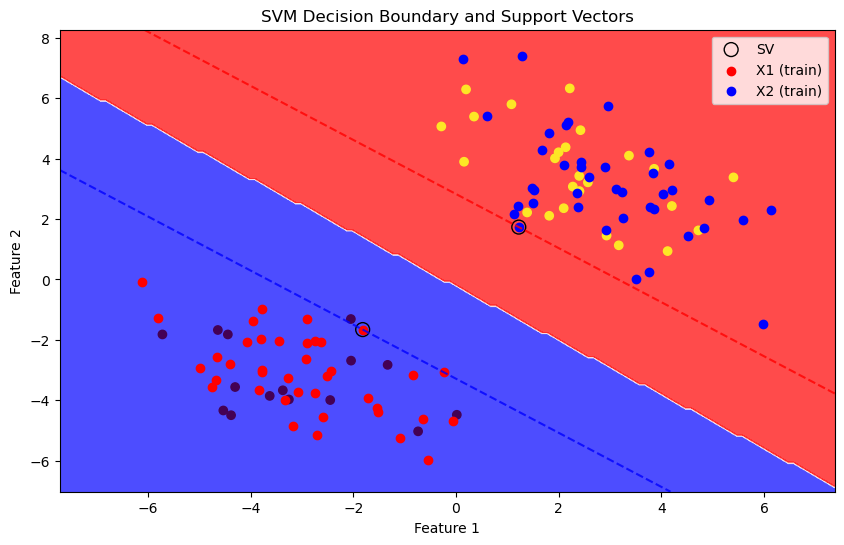

In [308]:
plot_decision_boundary(line_best_model, X_test, y_test, line_best_model.support_vectors_x)

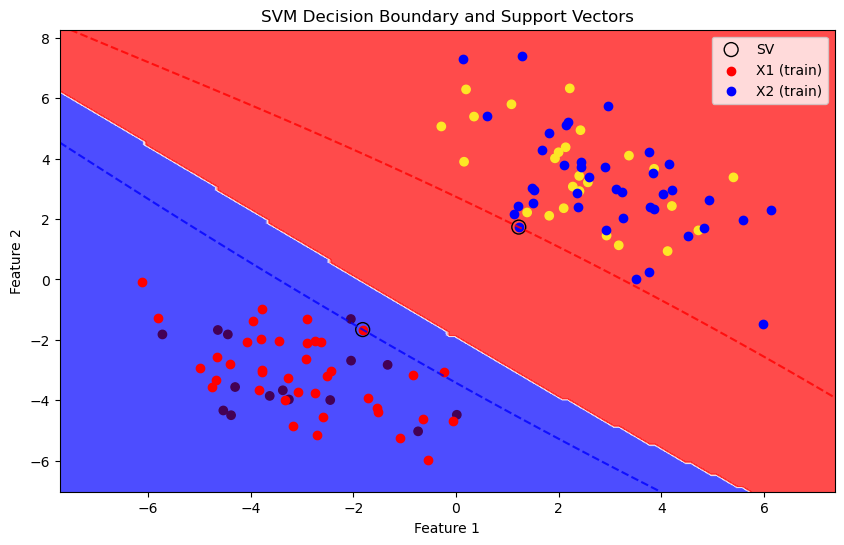

In [309]:
plot_decision_boundary(poly_best_model, X_test, y_test, poly_best_model.support_vectors_x)

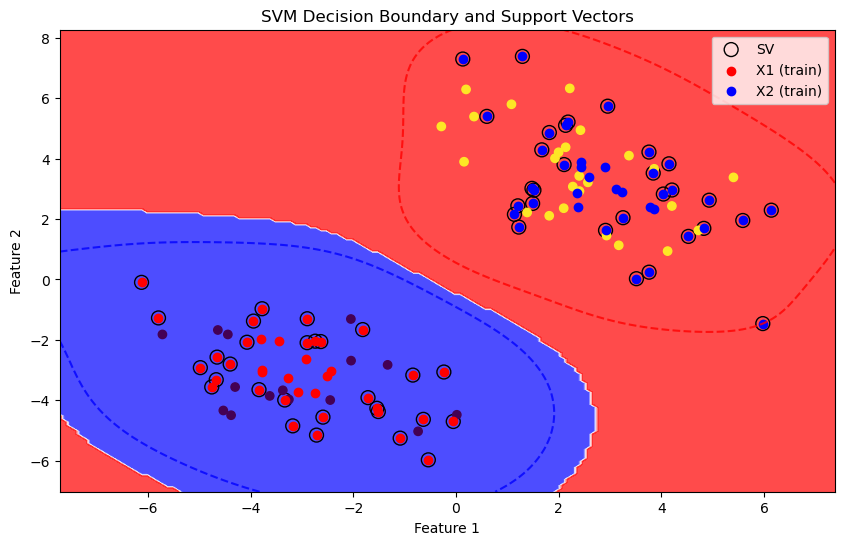

In [310]:
plot_decision_boundary(gaus_best_model, X_test, y_test, gaus_best_model.support_vectors_x)

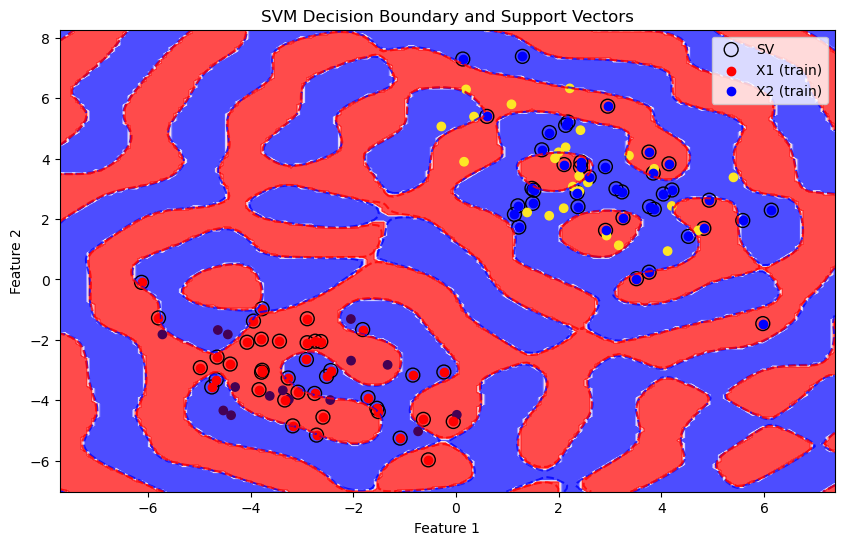

In [311]:
plot_decision_boundary(perio_best_model, X_test, y_test, perio_best_model.support_vectors_x)